In [28]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.svm import LinearSVC
from sklearn import svm 
from multiprocessing import Pool

import numpy as np

from effet_oppos.preprocessing import (
    parse_raw_data,
    parse_feature,
    normalize_data,
)
from effet_oppos.classification import (
    split_data,
    get_classifier,
    k_fold_crossvalid,
    train_model,
    predict_with_model,
    multi_predict_with_model,
    predict_top_classes,
    feature_importance,
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
taxa = core_tabler.taxonomy(normalized=False)
cities = core_tabler.metadata.loc[taxa.index, 'city']
big_cities = cities.value_counts()

big_cities

hong_kong         713
london            532
new_york_city     360
ilorin            246
singapore         186
tokyo             130
porto             112
barcelona         104
fairbanks          97
kyiv               95
taipei             94
seoul              90
lisbon             79
doha               72
stockholm          64
zurich             54
berlin             52
denver             37
rio_de_janeiro     34
sacramento         34
sao_paulo          29
oslo               28
offa               25
santiago           25
hamilton           16
honolulu           16
hanoi              16
sofia              16
marseille          16
vienna             16
paris              16
naples             16
bogota             15
brisbane           15
auckland           14
minneapolis        14
kuala_lumpur       14
sendai             14
san_francisco      14
baltimore          13
mexico_city        10
shanghai           10
yamaguchi           9
birmingham          7
bury                6
eastbourne

In [7]:


def one_trial(n):
    taxa = core_tabler.taxonomy(normalized=False)
    if n > 0:
        taxa = taxa.sample(n)
    cities = core_tabler.metadata.loc[taxa.index, 'city']
    big_cities = cities.value_counts()
    big_cities = big_cities[big_cities > 0].index

    cities = cities[cities.isin(big_cities)]
    taxa = taxa.loc[cities.index]
    taxa = taxa[taxa.sum(axis=1) != 0]

    feature, name_map = pd.factorize(cities)
    normalized = normalize_data(taxa, method='binary', threshold='0.0001')
    train_taxa, test_taxa, train_feature, test_feature = split_data(
            normalized, feature, test_size=0.1
    )
    model = train_model(
            train_taxa, train_feature, method='linear_svc',
            n_estimators=20, n_neighbours=21, n_components=10, seed=None
    )
    predictions = predict_with_model(model, test_taxa).round()
    return {
        'accuracy': accuracy_score(test_feature, predictions),
        'precision': precision_score(test_feature, predictions, average="micro"),
        'recall': recall_score(test_feature, predictions, average="micro"),
        'train_size': train_taxa.shape[0],
        'test_size': test_taxa.shape[0],
    }

tbl = []
for i in range(3):
    for n in [100, 200, 400, 800, 1600, 3200, -1]:
        print(n)
        val = one_trial(n)
        val['iter'] = i
        tbl.append(val)

tbl = pd.DataFrame(tbl)
tbl

100
200
400
800
1600
3200
-1
100
200
400
800
1600
3200
-1
100
200
400
800
1600
3200
-1


,accuracy,iter,precision,recall,test_size,train_size
0,0.400000,0,0.400000,0.400000,10,90
1,0.550000,0,0.550000,0.550000,20,180
2,0.600000,0,0.600000,0.600000,40,360
3,0.675000,0,0.675000,0.675000,80,720
4,0.812500,0,0.812500,0.812500,160,1440
5,0.896875,0,0.896875,0.896875,320,2880
6,0.901099,0,0.901099,0.901099,364,3275
7,0.300000,1,0.300000,0.300000,10,90
8,0.650000,1,0.650000,0.650000,20,180
9,0.725000,1,0.725000,0.725000,40,360


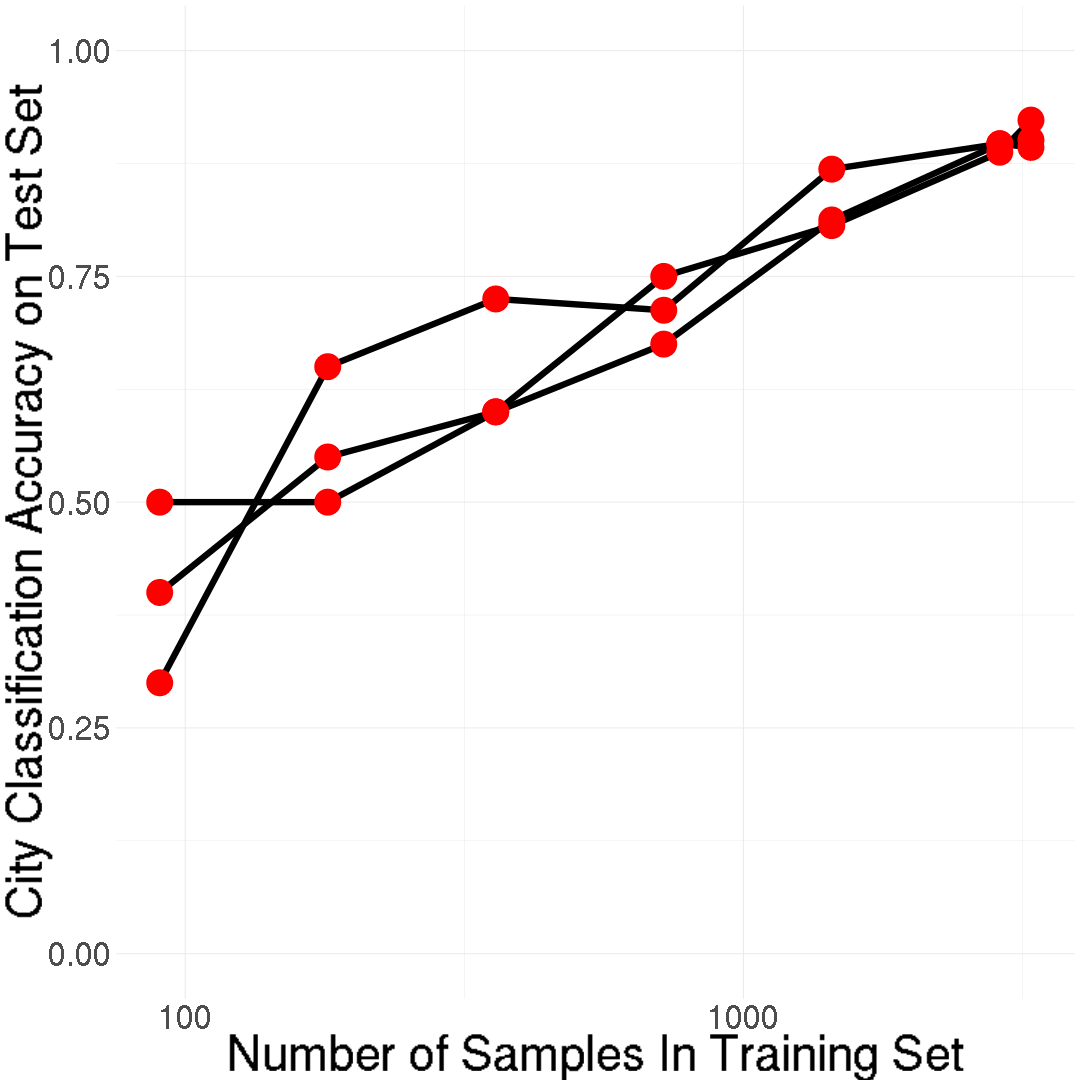

In [8]:
%%R -i tbl -w 1080 -h 1080

library(ggplot2)
library(RColorBrewer)

ggplot(tbl, aes(x=train_size, y=accuracy)) +
    geom_line(size=3, color='black', aes(group=iter)) +
    geom_point(size=12, width=0.1, color='red') +
    scale_x_log10() +
    xlab('Number of Samples In Training Set') +
    ylab('City Classification Accuracy on Test Set') +
    scale_color_brewer(palette='Set1') +
    theme_minimal() +
    ylim(0, 1.0) +
    theme(
        text=element_text(size=50)
    )

In [20]:
core_tabler = MetaSUBTableFactory.core_factory()

TAXA = core_tabler.taxonomy(normalized=True)
TAXA = TAXA[TAXA.sum(axis=1) != 0]
TAXA = TAXA > 0.00001

NPCS=1000
pca = PCA(n_components=NPCS, random_state=999)
pcs = pca.fit_transform(TAXA)
TAXA = pd.DataFrame(data=pcs, index=TAXA.index, columns=[f'PC{i}' for i in range(NPCS)])

normalized = TAXA
cities = core_tabler.metadata.loc[TAXA.index, 'city']
feature, name_map = pd.factorize(cities)


In [21]:
train_taxa, test_taxa, train_feature, test_feature = split_data(
        normalized, feature, test_size=0.1, seed=999
)
print(train_taxa.shape)
print(train_feature.shape)

(3275, 1000)
(3275,)


In [22]:
model = svm.SVC(kernel='linear', probability=True, random_state=999)
model.fit(train_taxa, train_feature)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

In [23]:


predictions = predict_with_model(model, test_taxa).round()
conf_matrix = pd.DataFrame(confusion_matrix(test_feature, predictions))
conf_matrix.index = [name_map[el] for el in conf_matrix.index]
conf_matrix.columns = [name_map[el] for el in conf_matrix.columns]
print(accuracy_score(test_feature, predictions))
print(precision_score(test_feature, predictions, average="micro"))
print(recall_score(test_feature, predictions, average="micro"))

0.9148351648351648
0.9148351648351648
0.9148351648351648


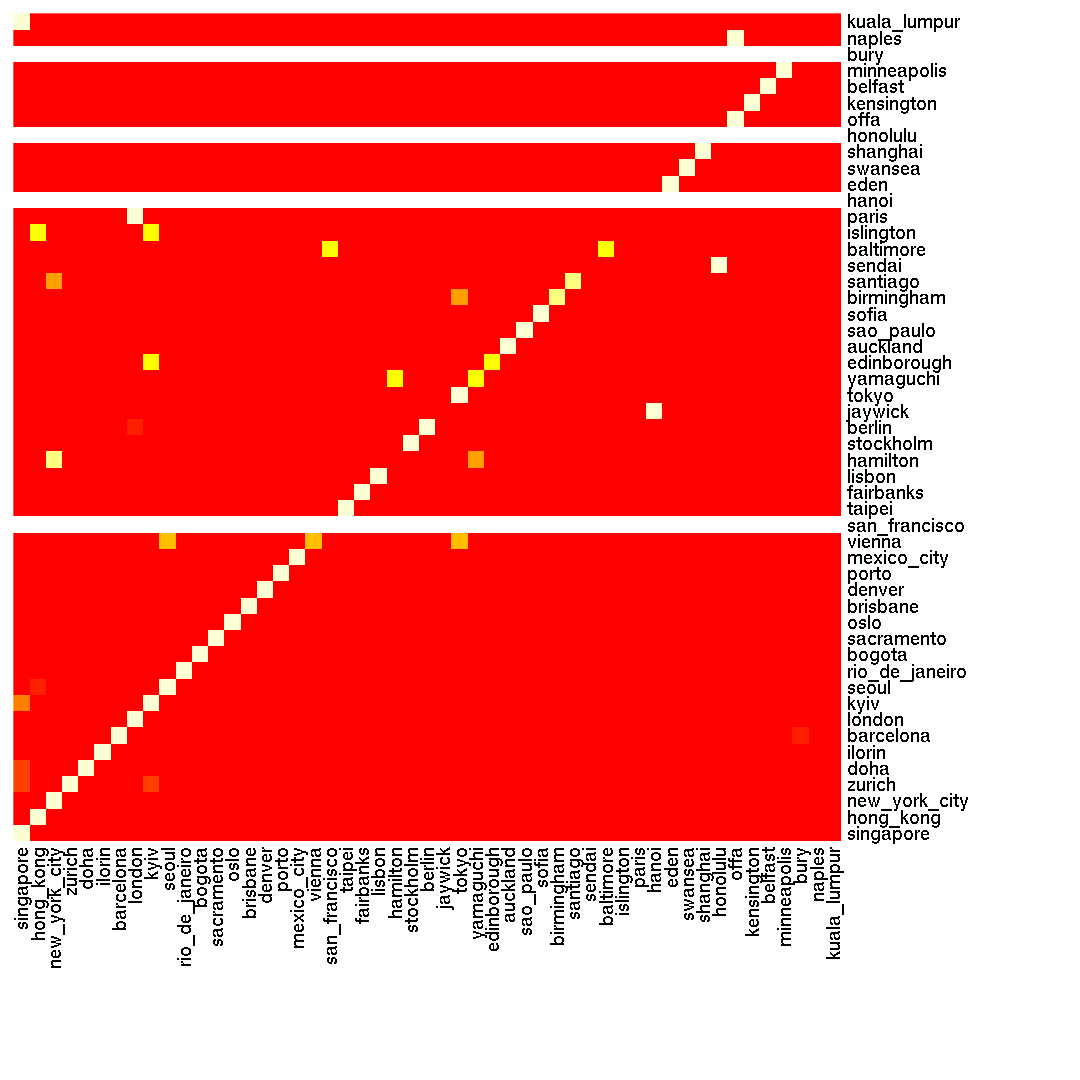

In [24]:
%%R -i conf_matrix -w 1080 -h 1080


heatmap(as.matrix(conf_matrix), Rowv=NA, Colv=NA, cexRow=2, cexCol=2, margins=c(20, 20))

In [13]:
from numpy.random import normal, lognormal

taxa_means = test_taxa.mean()
tbl = {}
for trial in range(3):
    for eps in [-5, -4, -3, -2, -1, 0, 1, 2]:
        noise_sds = (10 ** eps) * taxa_means
        
        noise_taxa = test_taxa.copy()
        for i in range(test_taxa.shape[1]):
            noise = normal(scale=noise_sds[i], size=test_taxa.shape[0])
            noise_taxa.iloc[:, i] += noise
        predictions = predict_with_model(model, noise_taxa).round()
        tbl[(eps, trial, 'normal')] = {
            'eps': 10 ** eps,
            'trial': trial,
            'distribution': 'normal',
            'accuracy': accuracy_score(test_feature, predictions),
            'precision': precision_score(test_feature, predictions, average="micro"),
            'recall': recall_score(test_feature, predictions, average="micro"),
        }
        '''
        noise_taxa = test_taxa.copy()
        for i in range(test_taxa.shape[1]):
            noise = lognormal(sigma=noise_sds[i], size=test_taxa.shape[0])
            noise_taxa.iloc[:, i] += noise
        predictions = predict_with_model(model, noise_taxa).round()
        tbl[(eps, trial, 'lognormal')] = {
            'eps': 10 ** eps,
            'trial': trial,
            'distribution': 'lognormal',
            'accuracy': accuracy_score(test_feature, predictions),
            'precision': precision_score(test_feature, predictions, average="micro"),
            'recall': recall_score(test_feature, predictions, average="micro"),
        }
        '''

noisy_results = pd.DataFrame.from_dict(tbl, orient='index')
noisy_results.head()

eps  trial distribution  accuracy  precision    recall
-5 0 normal  0.00001      0       normal  0.846154   0.846154  0.846154
   1 normal  0.00001      1       normal  0.846154   0.846154  0.846154
   2 normal  0.00001      2       normal  0.846154   0.846154  0.846154
-4 0 normal  0.00010      0       normal  0.846154   0.846154  0.846154
   1 normal  0.00010      1       normal  0.846154   0.846154  0.846154

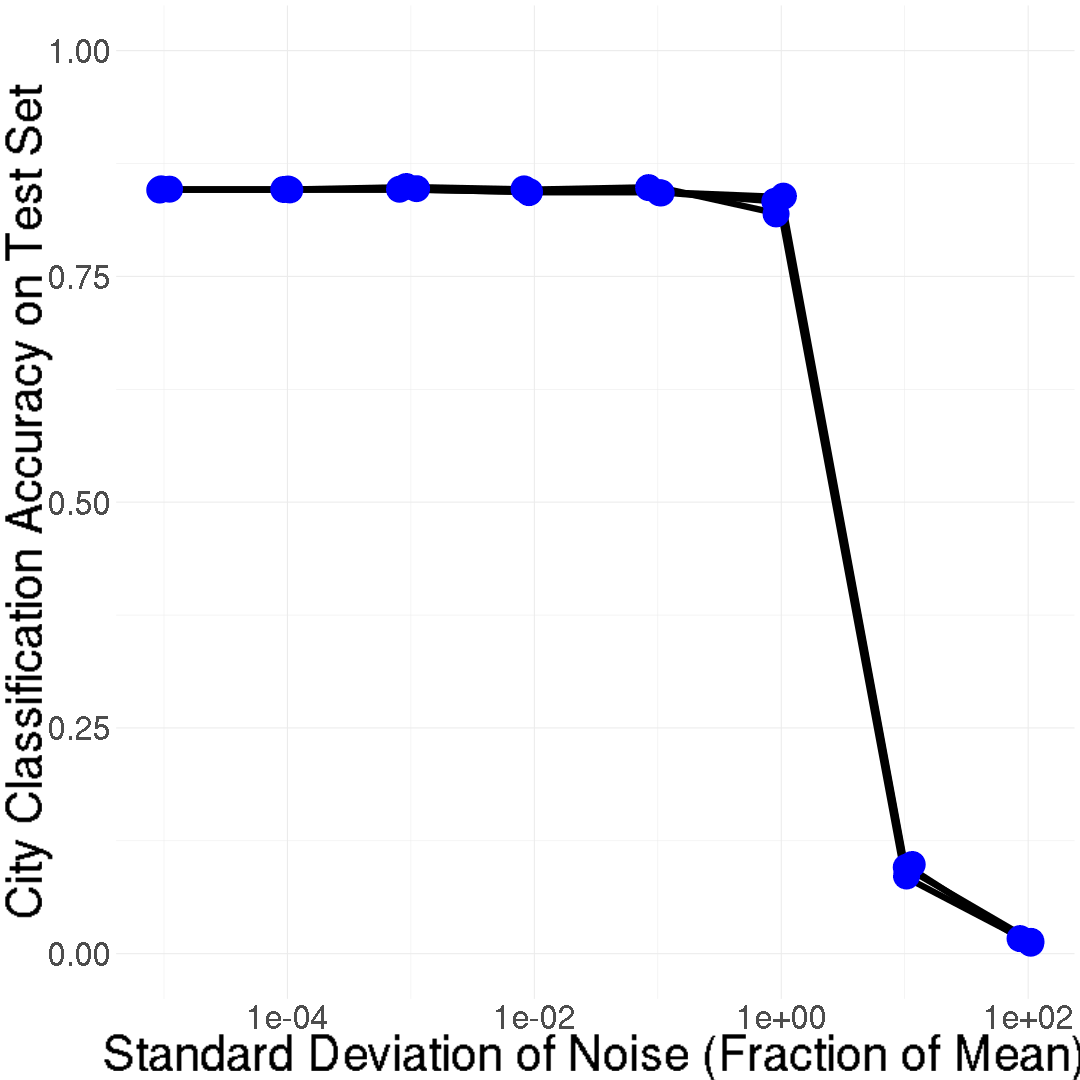

In [14]:
%%R -i noisy_results -w 1080 -h 1080

library(ggplot2)
library(RColorBrewer)

ggplot(noisy_results, aes(x=eps, y=precision)) +
    geom_line(size=3, color='black', aes(group=interaction(trial, distribution))) +
    geom_jitter(size=12, width=0.1, color='blue') +
    scale_x_log10() +
    #scale_y_log10() +
    xlab('Standard Deviation of Noise (Fraction of Mean)') +
    ylab('City Classification Accuracy on Test Set') +
    scale_color_brewer(palette='Set1') +
    theme_minimal() +
    ylim(0, 1.0) +
    theme(
        text=element_text(size=50)
    )

In [50]:

TAXA = core_tabler.taxonomy(normalized=True)
TAXA = TAXA[TAXA.sum(axis=1) != 0]
TAXA = TAXA > 0.00001

NPCS = 100
pca = PCA(n_components=NPCS, random_state=999)
pcs = pca.fit_transform(TAXA)
TAXA = pd.DataFrame(data=pcs, index=TAXA.index, columns=[f'PC{i}' for i in range(NPCS)])

COLS = [ 
    'city', 'city_latitude', 'city_longitude',
    'coastal_city', 'city_total_population', 'city_population_density', 
    'city_ave_june_temp_c', 'continent', 'city_koppen_climate',  
    'surface_ontology_fine', 'surface_ontology_coarse', 'city_elevation'
]
METADATA = core_tabler.metadata[COLS]

METADATA['city_ave_june_temp_c'] = pd.cut(METADATA['city_ave_june_temp_c'], 3, labels=['low', 'medium', 'high'])
METADATA['city_population_density'] = pd.cut(METADATA['city_population_density'], 3, labels=['low', 'medium', 'high'])
METADATA['city_total_population'] = pd.cut(METADATA['city_total_population'], 3, labels=['low', 'medium', 'high'])
METADATA['city_latitude'] = pd.cut(METADATA['city_latitude'], 5, labels=['-2', '-1', '0', '1', '2'])
METADATA['city_longitude'] = pd.cut(METADATA['city_longitude'], 5, labels=['-2', '-1', '0', '1', '2'])


def prep_data(leave_out_city, feature_to_predict):
    cities = METADATA.loc[TAXA.index, 'city']
    train_cities = cities[cities != leave_out_city]
    test_cities = cities[cities == leave_out_city]
    train_taxa = TAXA.loc[train_cities.index]
    test_taxa = TAXA.loc[test_cities.index]

    feature = METADATA.loc[TAXA.index, feature_to_predict]
    feature, name_map = pd.factorize(feature)
    test_feature = feature[TAXA.index.isin(test_cities.index)]
    train_feature = feature[TAXA.index.isin(train_cities.index)]
    test_names = list(test_cities.index)

    return (train_taxa, test_taxa), (train_feature, test_feature), name_map, test_names


def train_test_model(args):
    leave_out_city, feature_to_predict = args
    (train_taxa, test_taxa), (train_feature, test_feature), name_map, test_names = prep_data(leave_out_city, feature_to_predict)
    #classifier = RandomForestClassifier(n_estimators=40, random_state=0)
    classifier = LinearSVC(penalty='l2', dual=True, random_state=99)
    classifier.fit(train_taxa, train_feature)
    
    predictions = classifier.predict(test_taxa).round()
    confidences = [0] * len(predictions) # np.max(classifier.predict_proba(test_taxa), axis=1)
    assert len(predictions) == len(confidences)
    
    predictions = [name_map[el] for el in predictions]
    actual = [name_map[el] for el in test_feature]

    return pd.DataFrame([{
            'uuid': test_names[i],
            'predicted': predictions[i],
            'confidence': confidences[i],
            'actual': actual[i],
            'city': leave_out_city,
            'feature': feature_to_predict,
        } 
        for i in range(len(predictions))
    ])




In [51]:


tbls = []
with Pool(5) as p:
    args = []
    for city in core_tabler.metadata.loc[TAXA.index, 'city'].unique():
        if city in ['other', 'tsuruoka']:
            continue
        for feature in COLS:
            if feature in ['city']:
                continue
            args.append((city, feature))
    for i, tbl in enumerate(p.imap_unordered(train_test_model, args)):
            row = tbl.iloc[0]
            city, feature = row['city'], row['feature']
            if i % 10 == 0:
                print(f'{i} {city} {feature}')
            tbls.append(tbl)


tbl = pd.concat(tbls)
tbl.head()

0 singapore coastal_city
10 hong_kong city_longitude
20 new_york_city city_latitude
30 new_york_city city_elevation
40 zurich city_koppen_climate
50 doha continent
60 ilorin continent
70 barcelona city_population_density
80 london city_total_population
90 kyiv coastal_city
100 seoul coastal_city
110 seoul surface_ontology_coarse
120 rio_de_janeiro surface_ontology_coarse
130 sacramento city_longitude
140 sacramento city_elevation
150 oslo city_koppen_climate
160 brisbane continent
170 denver city_ave_june_temp_c
180 porto continent
190 porto surface_ontology_fine
200 vienna city_longitude
210 vienna surface_ontology_fine
220 san_francisco surface_ontology_coarse
230 taipei surface_ontology_coarse
240 lisbon city_latitude
250 lisbon city_elevation
260 hamilton city_koppen_climate
270 stockholm city_ave_june_temp_c
280 berlin city_ave_june_temp_c
290 jaywick city_population_density
300 tokyo city_total_population
310 yamaguchi city_total_population
320 yamaguchi surface_ontology_fine
330

,actual,city,confidence,feature,predicted,uuid
0,yes,singapore,0,coastal_city,yes,haib18CEM5453_HT5YVCCXY_SL357436
1,yes,singapore,0,coastal_city,yes,haib18CEM5453_HT5YVCCXY_SL357375
2,yes,singapore,0,coastal_city,no,haib18CEM5453_HT5YVCCXY_SL357405
3,yes,singapore,0,coastal_city,no,haib18CEM5453_HT5YVCCXY_SL357410
4,yes,singapore,0,coastal_city,no,haib18CEM5453_HT5YVCCXY_SL357373


In [52]:
tbl['correct'] = tbl['actual'] == tbl['predicted']

mytbl = pd.pivot_table(tbl, values=['correct'], columns=['feature'], index=['city', 'uuid'])
mytbl.columns = mytbl.columns.droplevel()
#mytbl = mytbl.drop(columns=['city'])

mytbl.groupby('city').mean().mean()

feature
city_ave_june_temp_c       0.552829
city_elevation             0.576737
city_koppen_climate        0.385825
city_latitude              0.515680
city_longitude             0.522026
city_population_density    0.532092
city_total_population      0.658395
coastal_city               0.601269
continent                  0.585694
surface_ontology_coarse    0.622925
surface_ontology_fine      0.374484
dtype: float64

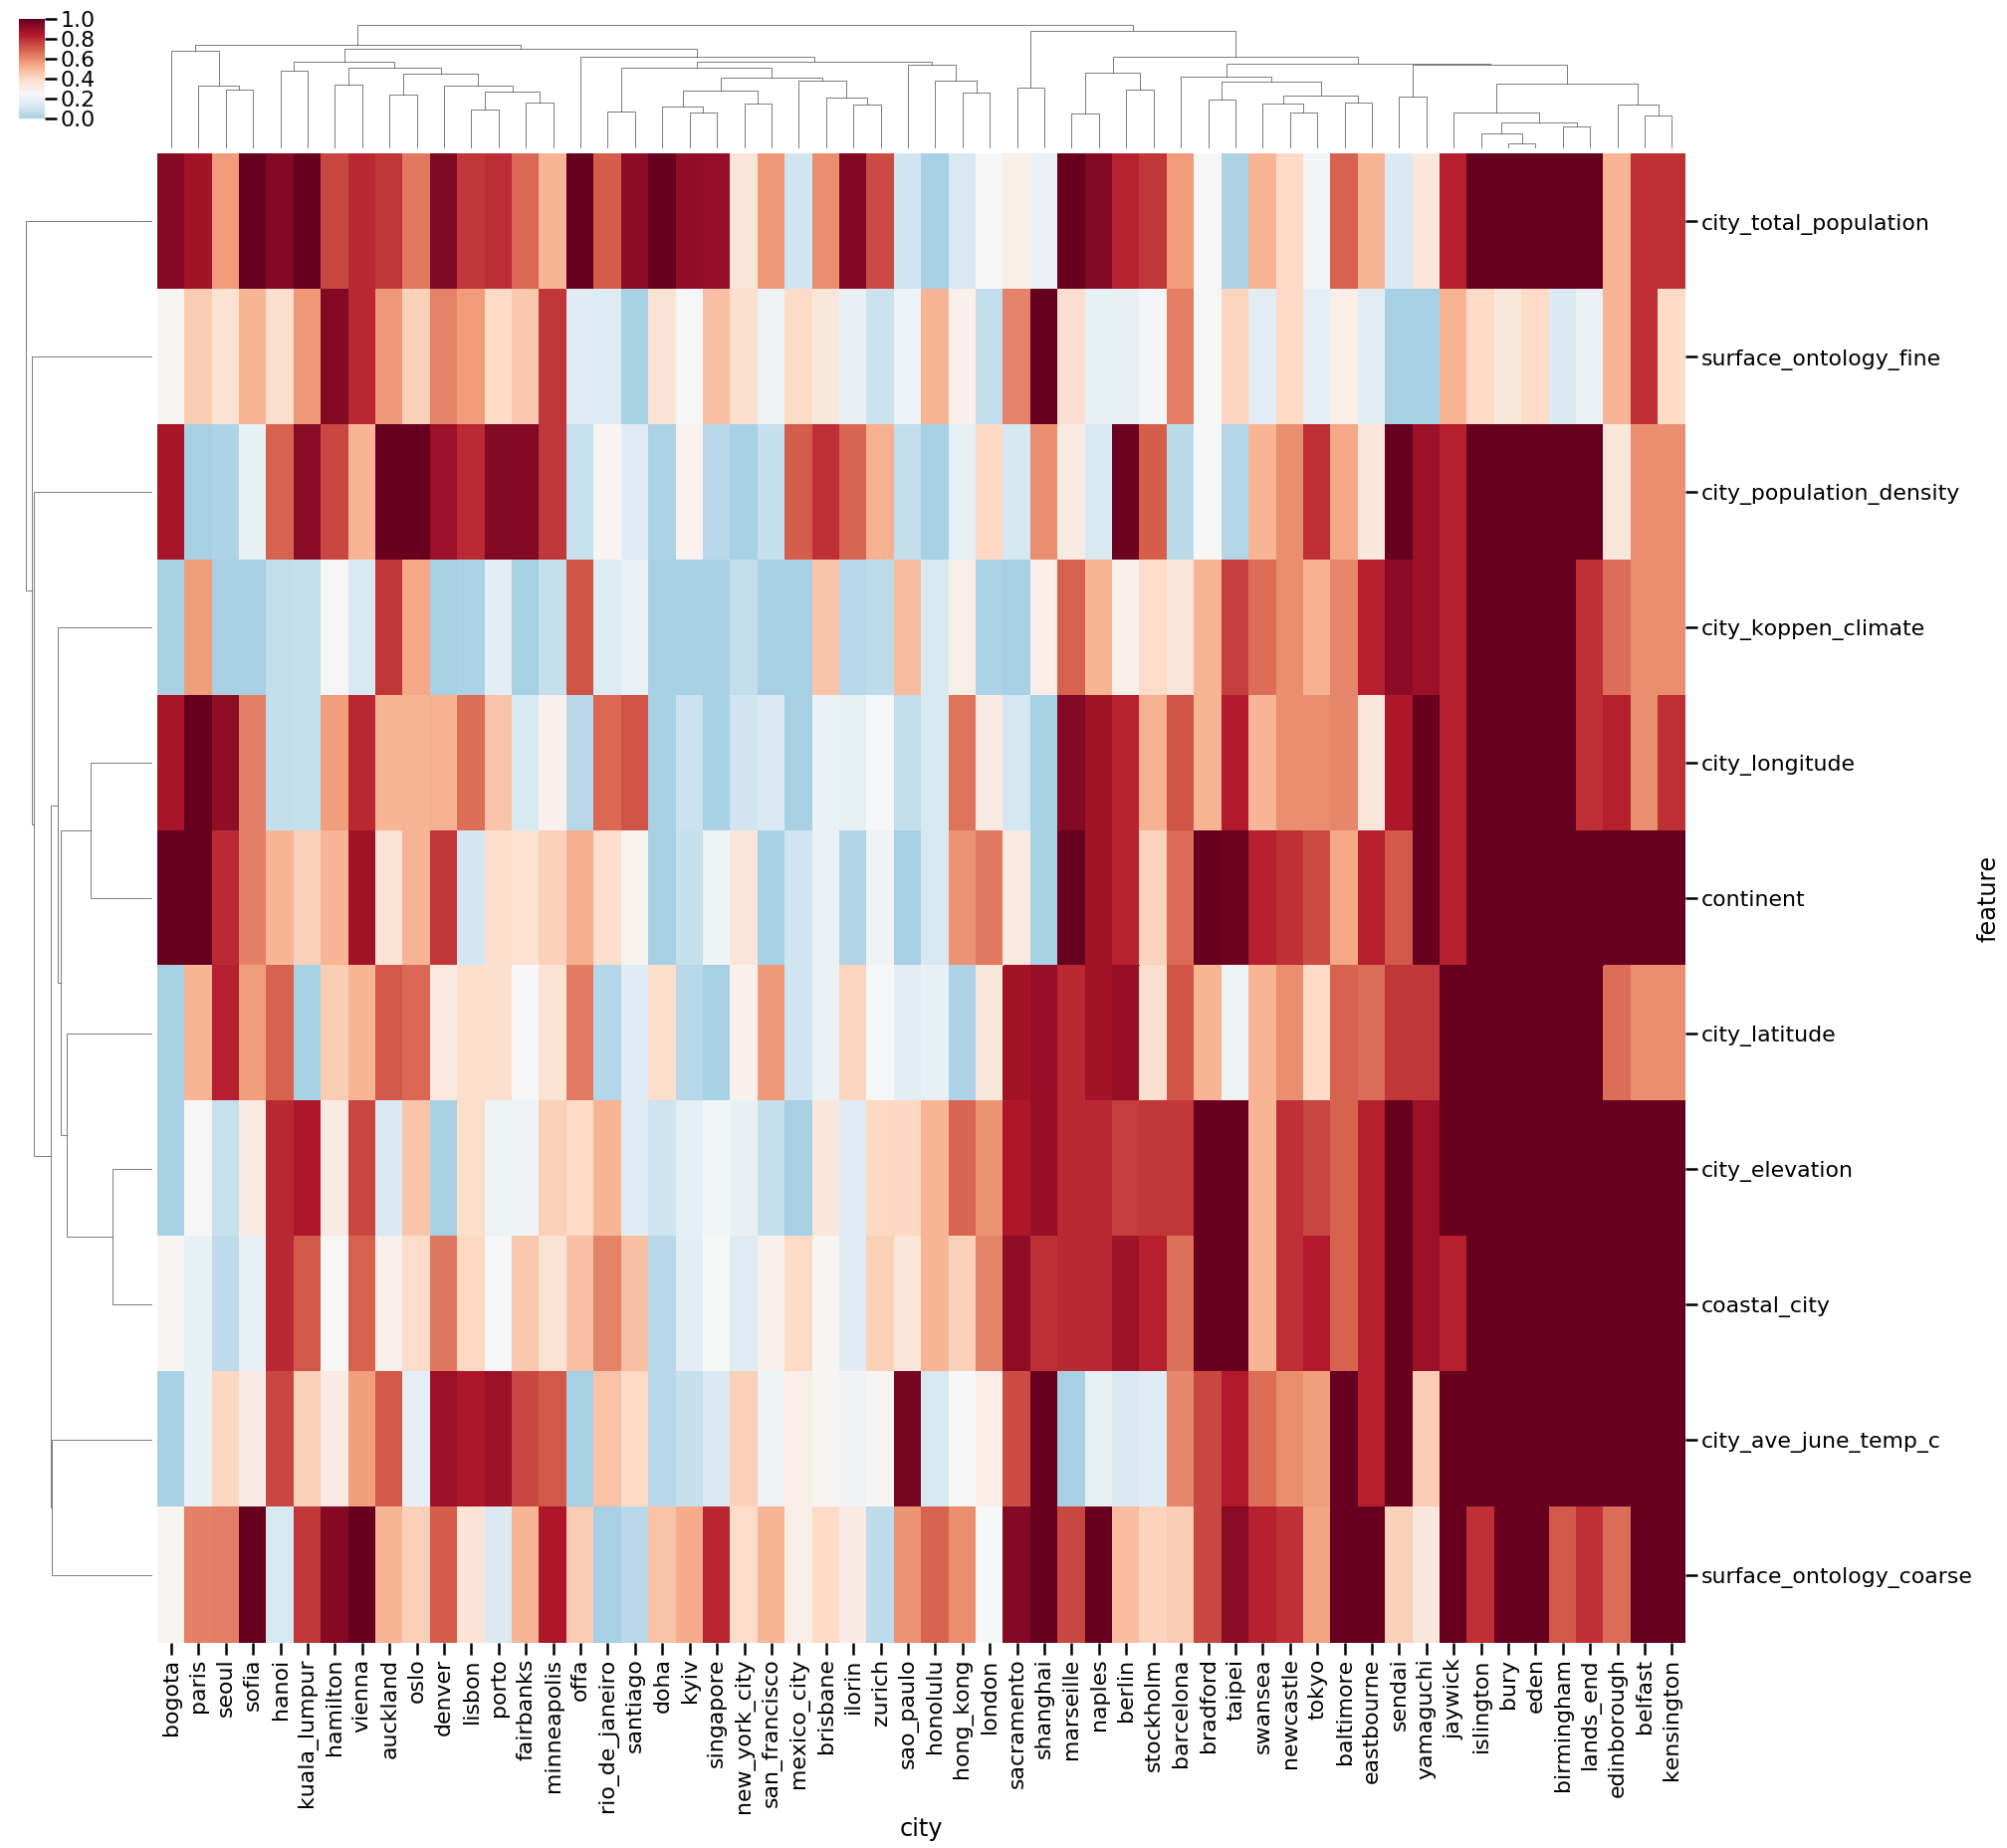

In [53]:
import seaborn as sns

sns.set_context("poster")
sns.clustermap(
    mytbl.groupby('city').mean().T,
    center=0.25, cmap="RdBu_r",
    figsize=(30, 30)
)

In [55]:
print(mytbl.groupby('city').mean().mean().to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
feature                 &           \\
\midrule
city\_ave\_june\_temp\_c    &  0.552829 \\
city\_elevation          &  0.576737 \\
city\_koppen\_climate     &  0.385825 \\
city\_latitude           &  0.515680 \\
city\_longitude          &  0.522026 \\
city\_population\_density &  0.532092 \\
city\_total\_population   &  0.658395 \\
coastal\_city            &  0.601269 \\
continent               &  0.585694 \\
surface\_ontology\_coarse &  0.622925 \\
surface\_ontology\_fine   &  0.374484 \\
\bottomrule
\end{tabular}



In [ ]:
%%R -i city_conf -w 1920 -h 1080

library(ggplot2)
library(RColorBrewer)


city_conf$conf = as.factor(city_conf$confidence)

ggplot(city_conf, aes(x=conf, y=value, fill=variable)) + 
    geom_boxplot() +
    scale_fill_brewer(palette='Set1') +
    theme_minimal() +
    theme(
        text = element_text(size=50),
        legend.position='right',
        #axis.text.x=element_text(angle=90, size=25),
        #axis.title.x=element_blank(),
        #axis.text.y=element_blank(),
        #axis.title.y=element_blank(),
    )